<a href="https://colab.research.google.com/github/priyanshusankhala/hasoc-hnlp/blob/main/1a_hi_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/HASOC/

/content/drive/MyDrive/HASOC


In [ ]:
ls

Analysis/            model/               __pycache__/
Bert-large-cased-0/  predictionstrue.txt  task1_baseline.py
Data/                predictions.txt      train_hi_sent.csv


In [ ]:
! pip install transformers
! pip install neptune-client
! pip install sentencepiece

train0

In [ ]:
###############################################################

# baseline code for task 1
# using BERT-based classification
# With the exception of the evaluation part 
# (which reflects the tasks evaluation code), 
# this code is taken from
# https://mccormickml.com/2019/07/22/BERT-fine-tuning/

###############################################################


import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from transformers import DistilBertModel, DistilBertConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import torch
import torch.nn as nn
import time
import datetime
import random
import os
import os.path
from sklearn import metrics
import neptune
load_model = False
save_model = False

if load_model:
    output_model_file = "/content/drive/MyDrive/HASOC/model/my_own_model_file.bin"
    output_config_file = "/content/drive/MyDrive/HASOC/model/my_own_config_file.bin"
    output_vocab_file = "/content/drive/MyDrive/HASOC/model/my_own_vocab_file.bin"


pre processing

In [ ]:
# Load the dataset into a pandas dataframe.
data = pd.read_csv("/content/drive/MyDrive/HASOC/Data/hi_Hasoc2021_train.csv", delimiter=',')
# dev_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_train.csv", delimiter=',', header=None, names=['id', 'sentence', 'label', 'alpha'])


In [ ]:
data.head()

,Unnamed: 0,_id,tweet_id,text,task_1,task_2
0,998,60c5d7495659ea5e55df0b7b,hi_hasoc_2021_998,@rssurjewala #Hindus DYING #HindusLivesMatter ...,NOT,NONE
1,4049,60c5d7495659ea5e55df1b73,hi_hasoc_2021_4049,सब लोग इतने पैसे डोनेट ही कर रहे हैं फिर भी आम...,NOT,NONE
2,1757,60c5d7495659ea5e55df0d1b,hi_hasoc_2021_1757,शेर-ए- सिवान शहाबुद्दीन साहब से रिश्ता क्या ل...,NOT,NONE
3,5175,60c5d7495659ea5e55df0e45,hi_hasoc_2021_5178,@AskAnshul आसमानी किताब के नाजायज औलाद है।,HOF,OFFN
4,1825,60c5d7495659ea5e55df0ee1,hi_hasoc_2021_1825,@Shikha0222 इसे कहते हैं दोगला पंती जिस सपा की...,NOT,NONE


In [ ]:
data.task_1.value_counts()

NOT    3161
HOF    1433
Name: task_1, dtype: int64

In [ ]:
device = torch.device("cuda")

In [ ]:
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
# tokenizer_hi = AutoTokenizer.from_pretrained("salesken/translation-hi-en")
# model_hi = AutoModelForSeq2SeqLM.from_pretrained("salesken/translation-hi-en")


In [ ]:
# tokenizer_hi = tokenizer_hi.to(device)
# model_hi = model_hi.to(device)

In [ ]:
# def translate(input_):
    
#   hin_snippet = input_
#   inputs = tokenizer_hi.encode(
#       hin_snippet, return_tensors="pt",padding=True,max_length=200,truncation=True)

#   outputs = model_hi.generate(
#       inputs.to(device), max_length=128, num_beams=None, early_stopping=True)

#   translated = tokenizer_hi.decode(outputs[0]).replace('<pad>',"").strip().lower()
#   return translated

In [ ]:
# A = data.text.apply(translate)

In [ ]:
# A.to_csv("/content/drive/MyDrive/HASOC/Data/hi_train_sent_trans.csv", index=False, header=['text'])

In [ ]:
data.text

0       @rssurjewala #Hindus DYING #HindusLivesMatter ...
1       सब लोग इतने पैसे डोनेट ही कर रहे हैं फिर भी आम...
2       शेर-ए- सिवान शहाबुद्दीन साहब से रिश्ता क्या  ل...
3              @AskAnshul आसमानी किताब के नाजायज औलाद है।
4       @Shikha0222 इसे कहते हैं दोगला पंती जिस सपा की...
                              ...                        
4589    सिवान के पुर्व सांसद मरहुम मो सहाबुदीन के रहस्...
4590    वर्ष 1989-1990 के दौरान कश्मीर के हिंदुओं के स...
4591    #किसानों_का_मोदी_को_धोबीपटका #ResignPMmodi htt...
4592    @Ravishk356 @newslaundry @abhisar_sharma मोदी ...
4593    बिहार के लोगों इन झूठे मक्कार राजनेताओं का चहर...
Name: text, Length: 4594, dtype: object

In [ ]:
A = pd.read_csv("/content/drive/MyDrive/HASOC/Data/hi_train_sent_trans.csv")

In [ ]:
A

,text
0,[citation needed] [citation needed]
1,"while everyone is doing so much money, the com..."
2,what is your relationship with sher-e-shahbudd...
3,@sknashul is the child of the book.
4,the samajwadi party (sp) @shikhha222 is saying...
...,...
4589,lakhs of separatists and their families have t...
4590,the same would have happened with hindus of ka...
4591,#kisans_kmodi_ko_dhobipatka #reptipmmodi https...
4592,@rashishk356 @newsandry @bhaisar_sharmamodi yo...


In [ ]:
data.task_1 = data.task_1.str.replace('NOT','0')
data.task_1 = data.task_1.str.replace('HOF','1')
data.task_1 = data.task_1.astype(int)
data.task_2 = data.task_2.str.replace('PRFN','0')
data.task_2 = data.task_2.str.replace('OFFN','1')
data.task_2 = data.task_2.str.replace('NONE','2')
data.task_2 = data.task_2.str.replace('HATE','3')
data.task_2 = data.task_2.astype(int)
data.text = A
df2 = data.copy()
df = df2.sample(frac=0.8, random_state=0)
dev_df = df2.drop(df.index)

In [ ]:
data.text

0                     [citation needed] [citation needed]
1       while everyone is doing so much money, the com...
2       what is your relationship with sher-e-shahbudd...
3                     @sknashul is the child of the book.
4       the samajwadi party (sp) @shikhha222 is saying...
                              ...                        
4589    lakhs of separatists and their families have t...
4590    the same would have happened with hindus of ka...
4591    #kisans_kmodi_ko_dhobipatka #reptipmmodi https...
4592    @rashishk356 @newsandry @bhaisar_sharmamodi yo...
4593    when the people of bihar should always remembe...
Name: text, Length: 4594, dtype: object

In [ ]:
df2 = data.copy()
df = df2.sample(frac=0.8, random_state=0)
dev_df = df2.drop(df.index)

In [ ]:
df.head()

,Unnamed: 0,_id,tweet_id,text,task_1,task_2
2472,1006,60c5d7495659ea5e55df0922,hi_hasoc_2021_1006,narendra_modi_gloyber_expo #modikavijamla #mod...,0,2
3255,1670,60c5d7495659ea5e55df0ff1,hi_hasoc_2021_1670,"@jiooti2831654@dr_uditraj friends, let us all ...",0,2
3546,1656,60c5d7495659ea5e55df0e29,hi_hasoc_2021_1656,a lot of memory will come to you. whenever a p...,0,2
727,5077,60c5d7495659ea5e55df0dc3,hi_hasoc_2021_5080,@ bhaburao_e_ato_apo_ankh @ @twidi_ @tirpatisp...,0,2
1697,1590,60c5d7495659ea5e55df0cec,hi_hasoc_2021_1590,mamata banerjee not to get into @mamataofficial,1,1


In [ ]:
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))


Number of training sentences: 3,675



In [ ]:
# Get the lists of sentences and their labels.
sentences = df.text.values
labels = df.task_1.values
labels

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
df.task_1.value_counts()

0    2540
1    1135
Name: task_1, dtype: int64

In [ ]:
# Get the lists of sentences and their labels.
dev_sentences = dev_df.text.values
dev_labels = dev_df.task_1.values

train 1

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
if load_model:
    tokenizer = AutoTokenizer.from_pretrained("bert-larged-case",do_lower_case = False)
    #tokenizer = AutoTokenizer.from_pretrained("verloop/Hinglish-Bert-Class")
    #tokenizer = AutoTokenizer.from_pretrained("verloop/Hinglish-DistilBert-Class")
    #tokenizer = BertTokenizer.from_pretrained('verloop/Hinglish-DistilBert-Class', do_lower_case = False)
else:
    tokenizer = AutoTokenizer.from_pretrained("bert-large-cased",do_lower_case = False)
    #tokenizer = AutoTokenizer.from_pretrained("verloop/Hinglish-Bert-Class")
    #tokenizer = AutoTokenizer.from_pretrained("verloop/Hinglish-DistilBert-Class")
    #tokenizer = BertTokenizer.from_pretrained('verloop/Hinglish-DistilBert-Class', do_lower_case=False)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
dev_input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# For every sentence...
for sent in dev_sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
    
    # Add the encoded sentence to the list.
    dev_input_ids.append(encoded_sent)

Loading BERT tokenizer...


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
l = [len(x) for x in input_ids]

In [ ]:
np.quantile(l, 0.999)

108.65200000000004

(array([6.640e+02, 1.569e+03, 8.320e+02, 3.460e+02, 1.550e+02, 5.100e+01,
        4.600e+01, 9.000e+00, 2.000e+00, 1.000e+00]),
 array([  3. ,  16.9,  30.8,  44.7,  58.6,  72.5,  86.4, 100.3, 114.2,
        128.1, 142. ]),
 <a list of 10 Patch objects>)

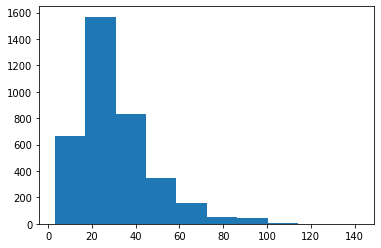

In [ ]:
np.histogram(l)
plt.hist(l)

In [ ]:
tokenizer.pad_token_id

0

In [ ]:
# We'll borrow the `pad_sequences` utility function to do this.

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 200

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
pad_token = tokenizer.pad_token_id

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=pad_token, truncating="post", padding="post")

dev_input_ids = pad_sequences(dev_input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=pad_token, truncating="post", padding="post")

print('\nDone.')

# Create attention masks
attention_masks = []
dev_attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    #att_mask = [int(token_id > 0) for token_id in sent]
    att_mask = [int(token_id != pad_token) for token_id in sent]
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

# For each sentence...
for sent in dev_input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    #att_mask = [int(token_id > 0) for token_id in sent]
    att_mask = [int(token_id != pad_token) for token_id in sent]
    # Store the attention mask for this sentence.
    dev_attention_masks.append(att_mask)
    

# Use 90% for training and 10% for validation.
train_inputs = input_ids 
validation_inputs = dev_input_ids
train_labels = labels
validation_labels = dev_labels

# Do the same for the masks.
train_masks =  attention_masks
validation_masks = dev_attention_masks
                                             
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs).to(torch.int64)
validation_inputs = torch.tensor(validation_inputs).to(torch.int64)

train_labels = torch.tensor(train_labels).to(torch.int64)
validation_labels = torch.tensor(validation_labels).to(torch.int64)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


Padding/truncating all sentences to 100 values...

Padding token: "[PAD]", ID: 0

Done.


In [ ]:
#model = AutoModelForSequenceClassification.from_pretrained("verloop/Hinglish-Bert-Class", output_attentions = False,output_hidden_states = False)
model = AutoModelForSequenceClassification.from_pretrained("bert-large-cased", output_attentions = False,output_hidden_states = False)
# model.classifier = nn.Linear(768,2)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

In [ ]:
model

In [ ]:
# Tell pytorch to run this model on the GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#model.cuda()
print(device)


# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    
learning_rate = 2e-5
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
use_neptune = 1                                            
if use_neptune:
    api = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4NDRkYTliMS1lZGRjLTRhOWMtOGU0ZC04OTEzNzU1Y2E2Y2MifQ=="
    neptune.init(project_qualified_name='hnlp.hasoc/nlp', api_token=api)
    PARAMS = {'lr': learning_rate,}
    tags = ['bert']
    neptune.create_experiment("First_exp", tags=tags, params=PARAMS)
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
    

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
# Store the average loss after each epoch so we can plot them.
loss_values = []
criterion = nn.CrossEntropyLoss(weight = torch.Tensor([1/3,2/3]).to(device))
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    #new
    train_loss = []
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device).long()

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        logits = outputs[0]
        loss = criterion(logits,b_labels)
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        neptune.log_metric("Loss_Train",loss.item())
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        #new
        train_loss.append(loss.item())
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    #print("  training loss: {0:.2f}".format(train_loss))
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    predictions , true_labels = [], []

    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        ##
        predictions.append(logits)
        true_labels.append(label_ids)
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1
        neptune.log_metric("Acc_Val",tmp_eval_accuracy)
    
        # Combine the predictions for each batch into a single list of 0s and 1s.
    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

        # Combine the correct labels for each batch into a single list.
    flat_true_labels = [item for sublist in true_labels for item in sublist]
        
    def evaluate(y_true, y_pred):
    
        assert len(y_true) == len(y_pred)
        precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true, y_pred, labels=[0, 1], average='weighted')
        scores = [
            "F1: %f\n" % f1,
            "Recall: %f\n" % recall,
            "Precision: %f\n" % precision,
            "ExactMatch: %f\n" % -1.0
        ]
        for s in scores:
            print(s, end='')
        # Evaluate predictions    
    evaluate(flat_true_labels, flat_predictions)
    # Calculate the accuracy for this batch of test sentences.
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    
    def func_call_test(epoch_id):
      #test_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_test_task1.csv", delimiter=',') #, header=None, names=['id', 'sentence', 'label']
      test_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/hi_Hasoc2021_test1_task1.csv", delimiter=',', header=None, names=['id', 'sentence', 'label'])
      # data.task_1 = data.task_1.str.replace('NOT','0')
      # data.task_1 = data.task_1.str.replace('HOF','1')
      # data.task_1 = data.task_1.astype(int)
      test_sentences = test_df.sentence.values
      test_labels = test_df.label.values
      # Report the number of sentences.
      print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))
      # /Check This
      # Will this make sense now?
      # Since the files are no longer loading with the gives headers. Think about it and give the necessary loading names
      # /
      # /test_sentences = test_df.sentence.values ##
      # /test_labels = test_df.label.values
      # / UNcomment/delete after done
      # Tokenize all of the sentences and map the tokens to thier word IDs.
      test_input_ids = []

      # For every sentence...
      for sent in test_sentences:
          # `encode` will:
          #   (1) Tokenize the sentence.
          #   (2) Prepend the `[CLS]` token to the start.
          #   (3) Append the `[SEP]` token to the end.
          #   (4) Map tokens to their IDs.
          encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
          
          test_input_ids.append(encoded_sent)
      pad_token = tokenizer.pad_token_id
      # Pad our input tokens
      test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, value = pad_token, 
                                dtype="long", truncating="post", padding="post")

      # Create attention masks
      test_attention_masks = []

      # Create a mask of 1s for each token followed by 0s for padding
      for seq in test_input_ids:
        seq_mask = [int(i != pad_token) for i in seq]
        #seq_mask = [int(i!= pad_token) for i in seq]
        #seq_mask = [float(i>0) for i in seq]
        test_attention_masks.append(seq_mask) 

      # Convert to tensors.
      prediction_inputs = torch.tensor(test_input_ids).to(torch.int64)
      prediction_masks = torch.tensor(test_attention_masks)
      prediction_labels = torch.tensor(test_labels).to(torch.int64)

      # Set the batch size.  
      batch_size = 8  

      # Create the DataLoader.
      prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
      prediction_sampler = SequentialSampler(prediction_data)
      prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

      # Prediction on test set

      print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

      # Put model in evaluation mode
      model.eval()

      # Tracking variables 
      predictions , true_labels = [], []
    
      # Predict 
      for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, 
                            attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

      print('    DONE.')

      print('Positive samples: %d of %d (%.2f%%)' % (test_df.label.sum(), len(test_df.label), (test_df.label.sum() / len(test_df.label) * 100.0)))
      with open('/content/drive/MyDrive/HASOC/Data/predictionstrue_hi_bert.csv', "w") as writer:
          for i,line in enumerate(predictions):
              writer.write(str(line) +" " +str(true_labels[i]) + "\n")
        
      # Combine the predictions for each batch into a single list of 0s and 1s.
      flat_predictions = [item for sublist in predictions for item in sublist]
      flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

      # Combine the correct labels for each batch into a single list.
      flat_true_labels = [item for sublist in true_labels for item in sublist]

      def evaluate(y_true, y_pred):
          """
          Evaluate Precision, Recall, F1 scores between y_true and y_pred
          If output_file is provided, scores are saved in this file otherwise printed to std output.
          :param y_true: true labels
          :param y_pred: predicted labels
          :return: list of scores (F1, Recall, Precision, ExactMatch)
          """
          
          assert len(y_true) == len(y_pred)
          precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true, y_pred, labels=[0, 1], average='weighted')
          scores = [
              "F1: %f\n" % f1,
              "Recall: %f\n" % recall,
              "Precision: %f\n" % precision,
              "ExactMatch: %f\n" % -1.0
          ]
          for s in scores:
              print(s, end='')

      # Evaluate predictions    
      evaluate(flat_true_labels, flat_predictions)

      print('Writing predictions to file...')
      with open("/content/drive/MyDrive/HASOC/Data/statout_hi_bert_trans_"+str(epoch_i)+".csv", "w") as writer:
        for line in flat_predictions:
              writer.write(str(line) + "\n")
      #//Check this    
     # Save predictions to file
      with open('/content/drive/MyDrive/HASOC/Data/predictions_hibert1.csv', "w") as writer:
          for line in flat_predictions:
              writer.write(str(line) + "\n")
              
      print('Done writing predictions...')


      if(save_model):
          v = 0
          folder_name = "Bert-large-cased-" + str(v)
          if(os.path.exists(folder_name)):
              v+=1
              folder_name = "Bert-large-uncased-" + str(v)
          else:
              os.mkdir(folder_name)

          # output_model_file = "./{}/my_own_model_file.bin".format(folder_name)
          # output_config_file = "./{}/my_own_config_file.bin".format(folder_name)
          # output_vocab_file = "./{}/my_own_vocab_file.bin".format(folder_name)
          output_model_file = "/content/drive/MyDrive/HASOC/model/my_own_model_hifile.bin".format(model)
          output_config_file = "/content/drive/MyDrive/HASOC/model/my_own_config_hifile.bin".format(model)
          output_vocab_file = "/content/drive/MyDrive/HASOC/model/my_own_vocab_hifile.bin".format(model)

          # Step 1: Save a model, configuration and vocabulary that you have fine-tuned

          # If we have a distributed model, save only the encapsulated model
          # (it was wrapped in PyTorch DistributedDataParallel or DataParallel)
          model_to_save = model.module if hasattr(model, 'module') else model

          torch.save(model_to_save.state_dict(), output_model_file)
          model_to_save.config.to_json_file(output_config_file)
          tokenizer.save_vocabulary(output_vocab_file)

    func_call_test(epoch_i)
print("")
print("Training complete!")

# torch.save(model,'model.pth')
# model = torch.load('model.pth')
# Load the dataset into a pandas dataframe.

cuda
The BERT model has 393 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (28996, 1024)
bert.embeddings.position_embeddings.weight               (512, 1024)
bert.embeddings.token_type_embeddings.weight               (2, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.query.bias               (1024,)
bert.encoder.layer.0.attention.self.key.weight          (1024, 1024)
bert.encoder.layer.0.attention.self.key.bias                 (1024,)
bert.encoder.layer.0.attention.self.value.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.value.bias               (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias         

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1: 0.544975
Recall: 0.675734
Precision: 0.456617
ExactMatch: -1.000000
  Accuracy: 0.68
  Validation took: 0:00:37
Number of test sentences: 1,533

Predicting labels for 1,533 test sentences...
    DONE.
Positive samples: 0 of 1533 (0.00%)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1: 0.000000
Recall: 0.000000
Precision: 0.000000
ExactMatch: -1.000000
Writing predictions to file...
Done writing predictions...

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    230.    Elapsed: 0:01:18.
  Batch    80  of    230.    Elapsed: 0:02:36.
  Batch   120  of    230.    Elapsed: 0:03:54.
  Batch   160  of    230.    Elapsed: 0:05:13.
  Batch   200  of    230.    Elapsed: 0:06:31.

  Average training loss: 0.71
  Training epcoh took: 0:07:29

Running Validation...
F1: 0.556501
Recall: 0.675734
Precision: 0.620321
ExactMatch: -1.000000
  Accuracy: 0.68
  Validation took: 0:00:37
Number of test sentences: 1,533

Predicting labels for 1,533 test sentences...
    DONE.
Positive samples: 0 of 1533 (0.00%)
F1: 0.000000
Recall: 0.000000
Precision: 0.000000
ExactMatch: -1.000000
Writing predictions to file...
Done writing predictions...

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    230.    Elapsed: 0:01:18.
  Batch    80  of    230.    Elapsed: 0:02:3

In [ ]:
torch.cuda.empty_cache()

In [ ]:

data_test = pd.read_csv("/content/drive/MyDrive/HASOC/Data/hi_Hasoc2021_test1_task1.csv")

In [ ]:
B = data_test.text.apply(translate)

In [ ]:
B.to_csv("/content/drive/MyDrive/HASOC/Data/hi_test_sent_trans.csv", index=False, header=['text'])

In [ ]:
cuda
The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (28996, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)
bert.encoder.layer.0.attention.output.LayerNorm.weight        (768,)
bert.encoder.layer.0.attention.output.LayerNorm.bias          (768,)
bert.encoder.layer.0.intermediate.dense.weight           (3072, 768)
bert.encoder.layer.0.intermediate.dense.bias                 (3072,)
bert.encoder.layer.0.output.dense.weight                 (768, 3072)
bert.encoder.layer.0.output.dense.bias                        (768,)
bert.encoder.layer.0.output.LayerNorm.weight                  (768,)
bert.encoder.layer.0.output.LayerNorm.bias                    (768,)

==== Output Layer ====

bert.pooler.dense.weight                                  (768, 768)
bert.pooler.dense.bias                                        (768,)
classifier.weight                                           (2, 768)
classifier.bias                                                 (2,)
https://app.neptune.ai/hnlp.hasoc/nlp/e/NLP-37

======== Epoch 1 / 8 ========
Training...
  Batch    40  of    460.    Elapsed: 0:00:12.
  Batch    80  of    460.    Elapsed: 0:00:23.
  Batch   120  of    460.    Elapsed: 0:00:35.
  Batch   160  of    460.    Elapsed: 0:00:47.
  Batch   200  of    460.    Elapsed: 0:00:58.
  Batch   240  of    460.    Elapsed: 0:01:10.
  Batch   280  of    460.    Elapsed: 0:01:22.
  Batch   320  of    460.    Elapsed: 0:01:34.
  Batch   360  of    460.    Elapsed: 0:01:47.
  Batch   400  of    460.    Elapsed: 0:01:59.
  Batch   440  of    460.    Elapsed: 0:02:11.

  Average training loss: 0.71
  Training epcoh took: 0:02:17

Running Validation...
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F1: 0.158802
Recall: 0.324266
Precision: 0.105148
ExactMatch: -1.000000
  Accuracy: 0.32
  Validation took: 0:00:13
Number of test sentences: 1,533

Predicting labels for 1,533 test sentences...
    DONE.
Positive samples: 0 of 1533 (0.00%)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F1: 0.000000
Recall: 0.000000
Precision: 0.000000
ExactMatch: -1.000000
Writing predictions to file...
Done writing predictions...

======== Epoch 2 / 8 ========
Training...
  Batch    40  of    460.    Elapsed: 0:00:13.
  Batch    80  of    460.    Elapsed: 0:00:25.
  Batch   120  of    460.    Elapsed: 0:00:38.
  Batch   160  of    460.    Elapsed: 0:00:51.
  Batch   200  of    460.    Elapsed: 0:01:04.
  Batch   240  of    460.    Elapsed: 0:01:17.
  Batch   280  of    460.    Elapsed: 0:01:30.
  Batch   320  of    460.    Elapsed: 0:01:43.
  Batch   360  of    460.    Elapsed: 0:01:56.
  Batch   400  of    460.    Elapsed: 0:02:10.
  Batch   440  of    460.    Elapsed: 0:02:23.

  Average training loss: 0.66
  Training epcoh took: 0:02:30

Running Validation...
F1: 0.720951
Recall: 0.715996
Precision: 0.729932
ExactMatch: -1.000000
  Accuracy: 0.72
  Validation took: 0:00:13
Number of test sentences: 1,533

Predicting labels for 1,533 test sentences...
    DONE.
Positive samples: 0 of 1533 (0.00%)
F1: 0.000000
Recall: 0.000000
Precision: 0.000000
ExactMatch: -1.000000
Writing predictions to file...
Done writing predictions...

======== Epoch 3 / 8 ========
Training...
  Batch    40  of    460.    Elapsed: 0:00:13.
  Batch    80  of    460.    Elapsed: 0:00:27.
  Batch   120  of    460.    Elapsed: 0:00:40.
  Batch   160  of    460.    Elapsed: 0:00:54.
  Batch   200  of    460.    Elapsed: 0:01:07.
  Batch   240  of    460.    Elapsed: 0:01:21.
  Batch   280  of    460.    Elapsed: 0:01:34.
  Batch   320  of    460.    Elapsed: 0:01:48.
  Batch   360  of    460.    Elapsed: 0:02:01.
  Batch   400  of    460.    Elapsed: 0:02:15.
  Batch   440  of    460.    Elapsed: 0:02:28.

  Average training loss: 0.61
  Training epcoh took: 0:02:35

Running Validation...
F1: 0.743433
Recall: 0.750816
Precision: 0.741961
ExactMatch: -1.000000
  Accuracy: 0.75
  Validation took: 0:00:13
Number of test sentences: 1,533

Predicting labels for 1,533 test sentences...
    DONE.
Positive samples: 0 of 1533 (0.00%)
F1: 0.000000
Recall: 0.000000
Precision: 0.000000
ExactMatch: -1.000000
Writing predictions to file...
Done writing predictions...

======== Epoch 4 / 8 ========
Training...
  Batch    40  of    460.    Elapsed: 0:00:13.
  Batch    80  of    460.    Elapsed: 0:00:27.
  Batch   120  of    460.    Elapsed: 0:00:41.
  Batch   160  of    460.    Elapsed: 0:00:54.
  Batch   200  of    460.    Elapsed: 0:01:08.
  Batch   240  of    460.    Elapsed: 0:01:21.
  Batch   280  of    460.    Elapsed: 0:01:35.
  Batch   320  of    460.    Elapsed: 0:01:48.
  Batch   360  of    460.    Elapsed: 0:02:02.
  Batch   400  of    460.    Elapsed: 0:02:15.
  Batch   440  of    460.    Elapsed: 0:02:29.

  Average training loss: 0.58
  Training epcoh took: 0:02:35

Running Validation...
F1: 0.684826
Recall: 0.674646
Precision: 0.745799
ExactMatch: -1.000000
  Accuracy: 0.67
  Validation took: 0:00:13
Number of test sentences: 1,533

Predicting labels for 1,533 test sentences...
    DONE.
Positive samples: 0 of 1533 (0.00%)
F1: 0.000000
Recall: 0.000000
Precision: 0.000000
ExactMatch: -1.000000
Writing predictions to file...
Done writing predictions...

======== Epoch 5 / 8 ========
Training...
  Batch    40  of    460.    Elapsed: 0:00:13.
  Batch    80  of    460.    Elapsed: 0:00:27.
  Batch   120  of    460.    Elapsed: 0:00:41.
  Batch   160  of    460.    Elapsed: 0:00:54.
  Batch   200  of    460.    Elapsed: 0:01:08.
  Batch   240  of    460.    Elapsed: 0:01:21.
  Batch   280  of    460.    Elapsed: 0:01:35.
  Batch   320  of    460.    Elapsed: 0:01:48.
  Batch   360  of    460.    Elapsed: 0:02:02.
  Batch   400  of    460.    Elapsed: 0:02:15.
  Batch   440  of    460.    Elapsed: 0:02:29.

  Average training loss: 0.55
  Training epcoh took: 0:02:35

Running Validation...
F1: 0.749822
Recall: 0.758433
Precision: 0.749460
ExactMatch: -1.000000
  Accuracy: 0.76
  Validation took: 0:00:13
Number of test sentences: 1,533

Predicting labels for 1,533 test sentences...
    DONE.
Positive samples: 0 of 1533 (0.00%)
F1: 0.000000
Recall: 0.000000
Precision: 0.000000
ExactMatch: -1.000000
Writing predictions to file...
Done writing predictions...

======== Epoch 6 / 8 ========
Training...
  Batch    40  of    460.    Elapsed: 0:00:13.
  Batch    80  of    460.    Elapsed: 0:00:27.
  Batch   120  of    460.    Elapsed: 0:00:41.
  Batch   160  of    460.    Elapsed: 0:00:54.
  Batch   200  of    460.    Elapsed: 0:01:08.
  Batch   240  of    460.    Elapsed: 0:01:21.
  Batch   280  of    460.    Elapsed: 0:01:35.
  Batch   320  of    460.    Elapsed: 0:01:48.
  Batch   360  of    460.    Elapsed: 0:02:02.
  Batch   400  of    460.    Elapsed: 0:02:15.
  Batch   440  of    460.    Elapsed: 0:02:29.

  Average training loss: 0.55
  Training epcoh took: 0:02:35

Running Validation...
F1: 0.747901
Recall: 0.756257
Precision: 0.747227
ExactMatch: -1.000000
  Accuracy: 0.76
  Validation took: 0:00:13
Number of test sentences: 1,533

Predicting labels for 1,533 test sentences...
    DONE.
Positive samples: 0 of 1533 (0.00%)
F1: 0.000000
Recall: 0.000000
Precision: 0.000000
ExactMatch: -1.000000
Writing predictions to file...
Done writing predictions...

======== Epoch 7 / 8 ========
Training...
  Batch    40  of    460.    Elapsed: 0:00:13.
  Batch    80  of    460.    Elapsed: 0:00:27.
  Batch   120  of    460.    Elapsed: 0:00:40.
  Batch   160  of    460.    Elapsed: 0:00:54.
  Batch   200  of    460.    Elapsed: 0:01:08.
  Batch   240  of    460.    Elapsed: 0:01:21.
  Batch   280  of    460.    Elapsed: 0:01:35.
  Batch   320  of    460.    Elapsed: 0:01:48.
  Batch   360  of    460.    Elapsed: 0:02:02.
  Batch   400  of    460.    Elapsed: 0:02:15.
  Batch   440  of    460.    Elapsed: 0:02:29.

  Average training loss: 0.52
  Training epcoh took: 0:02:35

Running Validation...
F1: 0.728165
Recall: 0.724701
Precision: 0.733497
ExactMatch: -1.000000
  Accuracy: 0.72
  Validation took: 0:00:13
Number of test sentences: 1,533

Predicting labels for 1,533 test sentences...
    DONE.
Positive samples: 0 of 1533 (0.00%)
F1: 0.000000
Recall: 0.000000
Precision: 0.000000
ExactMatch: -1.000000
Writing predictions to file...
Done writing predictions...

======== Epoch 8 / 8 ========
Training...
  Batch    40  of    460.    Elapsed: 0:00:13.
  Batch    80  of    460.    Elapsed: 0:00:27.
  Batch   120  of    460.    Elapsed: 0:00:40.
  Batch   160  of    460.    Elapsed: 0:00:54.
  Batch   200  of    460.    Elapsed: 0:01:07.
  Batch   240  of    460.    Elapsed: 0:01:21.
  Batch   280  of    460.    Elapsed: 0:01:34.
  Batch   320  of    460.    Elapsed: 0:01:48.
  Batch   360  of    460.    Elapsed: 0:02:01.
  Batch   400  of    460.    Elapsed: 0:02:15.
  Batch   440  of    460.    Elapsed: 0:02:28.

  Average training loss: 0.52
  Training epcoh took: 0:02:35

Running Validation...
F1: 0.744911
Recall: 0.747552
Precision: 0.743173
ExactMatch: -1.000000
  Accuracy: 0.75
  Validation took: 0:00:13
Number of test sentences: 1,533

Predicting labels for 1,533 test sentences...
    DONE.
Positive samples: 0 of 1533 (0.00%)
F1: 0.000000
Recall: 0.000000
Precision: 0.000000
ExactMatch: -1.000000
Writing predictions to file...
Done writing predictions...

Training complete!

In [ ]:
    # predictions , true_labels = [], []
    # # Tracking variables 
    # eval_loss, eval_accuracy = 0, 0
    # nb_eval_steps, nb_eval_examples = 0, 0

    # # Evaluate data for one epoch
    # for batch in validation_dataloader:
        
    #     # Add batch to GPU
    #     batch = tuple(t.to(device) for t in batch)
        
    #     # Unpack the inputs from our dataloader
    #     b_input_ids, b_input_mask, b_labels = batch
        
    #     # Telling the model not to compute or store gradients, saving memory and
    #     # speeding up validation
    #     with torch.no_grad():        

    #         # Forward pass, calculate logit predictions.
    #         # This will return the logits rather than the loss because we have
    #         # not provided labels.
    #         # token_type_ids is the same as the "segment ids", which 
    #         # differentiates sentence 1 and 2 in 2-sentence tasks.
    #         # The documentation for this `model` function is here: 
    #         # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    #         outputs = model(b_input_ids, 
    #                         token_type_ids=None, 
    #                         attention_mask=b_input_mask)
        
    #     # Get the "logits" output by the model. The "logits" are the output
    #     # values prior to applying an activation function like the softmax.
    #     logits = outputs[0]

    #     # Move logits and labels to CPU
    #     logits = logits.detach().cpu().numpy()
    #     label_ids = b_labels.to('cpu').numpy()
        
        
    #     ## 
    #     predictions.append(logits)
    #     true_labels.append(label_ids)
    # # Combine the predictions for each batch into a single list of 0s and 1s.
    #     flat_predictions = [item for sublist in predictions for item in sublist]
    #     flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

    # # Combine the correct labels for each batch into a single list.
    #     flat_true_labels = [item for sublist in true_labels for item in sublist]
    #     def evaluate(y_true, y_pred):
    #     """
    #     Evaluate Precision, Recall, F1 scores between y_true and y_pred
    #     If output_file is provided, scores are saved in this file otherwise printed to std output.
    #     :param y_true: true labels
    #     :param y_pred: predicted labels
    #     :return: list of scores (F1, Recall, Precision, ExactMatch)
    #     """
        
    #     assert len(y_true) == len(y_pred)
    #     precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true, y_pred, labels=[0, 1], average='weighted')
    #     scores = [
    #         "F1: %f\n" % f1,
    #         "Recall: %f\n" % recall,
    #         "Precision: %f\n" % precision,
    #         "ExactMatch: %f\n" % -1.0
    #     ]
    #     for s in scores:
    #         print(s, end='')

        
    #     # Calculate the accuracy for this batch of test sentences.
    #     tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
    #     # Accumulate the total accuracy.
    #     eval_accuracy += tmp_eval_accuracy

    #     # Track the number of batches
    #     nb_eval_steps += 1
    #     neptune.log_metric("Acc_Val",tmp_eval_accuracy)
    # # Report the final accuracy for this validation run.
    # print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    # print("  Validation took: {:}".format(format_time(time.time() - t0)))


In [ ]:
# # Combine the predictions for each batch into a single list of 0s and 1s.
# flat_predictions = [item for sublist in predictions for item in sublist]
# flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# # Combine the correct labels for each batch into a single list.
# flat_true_labels = [item for sublist in true_labels for item in sublist]
# pd.concat([])
    def evaluate(y_true, y_pred):
        """
        Evaluate Precision, Recall, F1 scores between y_true and y_pred
        If output_file is provided, scores are saved in this file otherwise printed to std output.
        :param y_true: true labels
        :param y_pred: predicted labels
        :return: list of scores (F1, Recall, Precision, ExactMatch)
        """
        
        assert len(y_true) == len(y_pred)
        precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true, y_pred, labels=[0, 1], average='weighted')
        scores = [
            "F1: %f\n" % f1,
            "Recall: %f\n" % recall,
            "Precision: %f\n" % precision,
            "ExactMatch: %f\n" % -1.0
        ]
        for s in scores:
            print(s, end='')


In [ ]:
### TO REMOVE ONE COLUMN 

# test_df1 = pd.read_csv("/content/drive/MyDrive/HASOC/Data/hi_Hasoc2021_test_task1.csv", delimiter=',')
test_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/hi_Hasoc2021_test1_task1.csv", delimiter=',' , names=['id', 'sentence', 'label'])
# test_df1.drop('tweet_id', inplace = True, axis = 1)
# test_df1.to_csv("/content/drive/MyDrive/HASOC/Data/hi_Hasoc2021_test1_task1.csv", index=False)
# #test_df = test_df1.copy()
test_df.head()

# test_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_test_task1.csv", delimiter=',' , names=['id', 'sentence', 'label'])
# test_df.head()


,id,sentence,label
0,_id,text,NaN
1,60c5d7495659ea5e55df0546,@hemantmkpandya @news24tvchannel @Aloksharmaai...,NaN
2,60c5d7495659ea5e55df0591,वोडाफोन ने एक कुत्ता पाला था बहुत फेमस हुआ फ...,NaN
3,60c5d7495659ea5e55df0622,18-18 घंटे दीमक ने जाकर 70 साल के मज़बूत पेड़ ...,NaN
4,60c5d7495659ea5e55df0666,@dmfatehpur हमारे ग्राम पंचायत सिधांव जिला फते...,NaN


### New section


In [ ]:
#test_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/hi_Hasoc2021_test_task1.csv", delimiter=',')
test_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_test_task1.csv", delimiter=',' , names=['id', 'sentence', 'label'])
# data.task_1 = data.task_1.str.replace('NOT','0')
# data.task_1 = data.task_1.str.replace('HOF','1')
# data.task_1 = data.task_1.astype(int)
test_sentences = test_df.id.values
test_labels = test_df.sentence.values
test_labels = test_df.label.values
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))
# /Check This
# Will this make sense now?
# Since the files are no longer loading with the gives headers. Think about it and give the necessary loading names
# /
# /test_sentences = test_df.sentence.values ##
# /test_labels = test_df.label.values
# / UNcomment/delete after done
# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []

# For every sentence...
for sent in test_sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
    
    test_input_ids.append(encoded_sent)

# Pad our input tokens
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")
pad_token = tokenizer.pad_token_id
# Create attention masks
test_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in test_input_ids:
  seq_mask = [int(i != pad_token) for i in seq]
  test_attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(test_input_ids).to(torch.int64)
prediction_masks = torch.tensor(test_attention_masks)
prediction_labels = torch.tensor(test_labels).to(torch.int64)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

print('Positive samples: %d of %d (%.2f%%)' % (test_df.label.sum(), len(test_df.label), (test_df.label.sum() / len(test_df.label) * 100.0)))
with open('/content/drive/MyDrive/HASOC/Data/predictionstrue1.csv', "w") as writer:
    for i,line in enumerate(predictions):
        writer.write(str(line) +" " +str(true_labels[i]) + "\n")
  
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
print(flat_predictions)
# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

def evaluate(y_true, y_pred):
    """
    Evaluate Precision, Recall, F1 scores between y_true and y_pred
    If output_file is provided, scores are saved in this file otherwise printed to std output.
    :param y_true: true labels
    :param y_pred: predicted labels
    :return: list of scores (F1, Recall, Precision, ExactMatch)
    """
    
    assert len(y_true) == len(y_pred)
    precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true, y_pred, labels=[0, 1], average='weighted')
    scores = [
        "F1: %f\n" % f1,
        "Recall: %f\n" % recall,
        "Precision: %f\n" % precision,
        "ExactMatch: %f\n" % -1.0
    ]
    for s in scores:
        print(s, end='')

# Evaluate predictions    
evaluate(flat_true_labels, flat_predictions)

print('Writing predictions to file...')
with open("/content/drive/MyDrive/HASOC/Data/statout_B"+str(epoch_i)+".csv", "w") as writer:
  for line in flat_predictions:
        writer.write(str(line) + "\n")
#//Check this    
#// You had to interchange these two
# Save predictions to file
with open('/content/drive/MyDrive/HASOC/Data/predictions1.csv', "w") as writer:
    for line in flat_predictions:
        writer.write(str(line) + "\n")
        
print('Done writing predictions...')


if(save_model):
    v = 0
    folder_name = "Bert-large-cased-" + str(v)
    if(os.path.exists(folder_name)):
        v+=1
        folder_name = "Bert-large-uncased-" + str(v)
    else:
        os.mkdir(folder_name)

    # output_model_file = "./{}/my_own_model_file.bin".format(folder_name)
    # output_config_file = "./{}/my_own_config_file.bin".format(folder_name)
    # output_vocab_file = "./{}/my_own_vocab_file.bin".format(folder_name)
    output_model_file = "/content/drive/MyDrive/HASOC/model/my_own_model_file.bin".format(model)
    output_config_file = "/content/drive/MyDrive/HASOC/model/my_own_config_file.bin".format(model)
    output_vocab_file = "/content/drive/MyDrive/HASOC/model/my_own_vocab_file.bin".format(model)

    # Step 1: Save a model, configuration and vocabulary that you have fine-tuned

    # If we have a distributed model, save only the encapsulated model
    # (it was wrapped in PyTorch DistributedDataParallel or DataParallel)
    model_to_save = model.module if hasattr(model, 'module') else model

    torch.save(model_to_save.state_dict(), output_model_file)
    model_to_save.config.to_json_file(output_config_file)
    tokenizer.save_vocabulary(output_vocab_file)

Number of test sentences: 1,282

Predicting labels for 1,282 test sentences...
    DONE.
Positive samples: 0 of 1282 (0.00%)
[0 1 1 ... 1 1 1]
F1: 0.000000
Recall: 0.000000
Precision: 0.000000
ExactMatch: -1.000000
Writing predictions to file...
Done writing predictions...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_train.csv", delimiter=',')

In [ ]:
# data.task_1 = data.task_1.str.replace('NOT','0')
# data.task_1 = data.task_1.str.replace('HOF','1')
# data.task_1 = data.task_1.astype(int)
data.task_1.value_counts(normalize=True)

1    0.650794
0    0.349206
Name: task_1, dtype: float64

In [ ]:
import pandas as pd
df3 = pd.read_csv("/content/drive/MyDrive/HASOC/Data/statout_hi_bert3.csv", delimiter=',')
#df3.head()

# df3 = df3.iloc[: , 1:]
#len(df3)
df3.replace(0, 'NOT', inplace=True)  # for replacing nan to 0
df3.replace(1, 'HOF', inplace=True)  # for replacing nan to 0
df3.head()

# df3 = df3.str.replace('0','NOT')
# df3 = df3.str.replace('1', 'HOF')
# df3 = df3.astype(int)

,1
0,HOF
1,HOF
2,NOT
3,HOF
4,NOT


In [ ]:
df3.to_csv("/content/drive/MyDrive/HASOC/Data/hindi_meg_3.csv", index=False)

In [ ]:
# with open("/content/drive/MyDrive/HASOC/Data/statout"+str(epoch_i)+".csv", "w") as writer:
#   print ("reached here")
#   # for line in flat_predictions:
#   #           writer.write(str(line) + "\n")
# import numpy as np
# import pandas as pd

# d = {'one' : np.random.rand(10),
#      'two' : np.random.rand(10)}

# df = pd.DataFrame(d)

# df.plot(style=['o','rx'])
# import matplotlib.pyplot as plt
# # plt.scatter(data.task_1['_id'], data.task_1['train_loss'])
# # plt.show() # Depending on whether you use IPython or interactive mode, etc.
# plt.histogram(train_loss,da)

In [ ]:
# torch.save(model,'model.pth')
# model = torch.load('model.pth')
# Load the dataset into a pandas dataframe.
def func_call_test(epoch_id):
    #test_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_test_task1.csv", delimiter=',') #, header=None, names=['id', 'sentence', 'label']
    test_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/hi_Hasoc2021_test_task1.csv", delimiter=',', header=None, names=['id', 'sentence', 'label'])
    # data.task_1 = data.task_1.str.replace('NOT','0')
    # data.task_1 = data.task_1.str.replace('HOF','1')
    # data.task_1 = data.task_1.astype(int)

    # Report the number of sentences.
    print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))
    #/Check This
    #Will this make sense now?
    #Since the files are no longer loading with the gives headers. Think about it and give the necessary loading names
    #/
    #/test_sentences = test_df.sentence.values ##
    #/test_labels = test_df.label.values
    #/ UNcomment/delete after done
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    test_input_ids = []

    # For every sentence...
    for sent in test_sentences:
        # `encode` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
        
        test_input_ids.append(encoded_sent)

    # Pad our input tokens
    test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, 
                              dtype="long", truncating="post", padding="post")

    # Create attention masks
    test_attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in test_input_ids:
      seq_mask = [float(i>0) for i in seq]
      test_attention_masks.append(seq_mask) 

    # Convert to tensors.
    prediction_inputs = torch.tensor(test_input_ids).to(torch.int64)
    prediction_masks = torch.tensor(test_attention_masks)
    prediction_labels = torch.tensor(test_labels).to(torch.int64)

    # Set the batch size.  
    batch_size = 8  

    # Create the DataLoader.
    prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

    # Prediction on test set

    print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions , true_labels = [], []
   
    # Predict 
    for batch in prediction_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      
      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask)

      logits = outputs[0]

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      
      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

    print('    DONE.')

    print('Positive samples: %d of %d (%.2f%%)' % (test_df.label.sum(), len(test_df.label), (test_df.label.sum() / len(test_df.label) * 100.0)))
    with open('/content/drive/MyDrive/HASOC/Data/predictionstrue1.csv', "w") as writer:
        for i,line in enumerate(predictions):
            writer.write(str(line) +" " +str(true_labels[i]) + "\n")
      
    # Combine the predictions for each batch into a single list of 0s and 1s.
    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

    # Combine the correct labels for each batch into a single list.
    flat_true_labels = [item for sublist in true_labels for item in sublist]

    def evaluate(y_true, y_pred):
        """
        Evaluate Precision, Recall, F1 scores between y_true and y_pred
        If output_file is provided, scores are saved in this file otherwise printed to std output.
        :param y_true: true labels
        :param y_pred: predicted labels
        :return: list of scores (F1, Recall, Precision, ExactMatch)
        """
        
        assert len(y_true) == len(y_pred)
        precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true, y_pred, labels=[0, 1], average='weighted')
        scores = [
            "F1: %f\n" % f1,
            "Recall: %f\n" % recall,
            "Precision: %f\n" % precision,
            "ExactMatch: %f\n" % -1.0
        ]
        for s in scores:
            print(s, end='')

    # Evaluate predictions    
    evaluate(flat_true_labels, flat_predictions)

    print('Writing predictions to file...')
    with open("/content/drive/MyDrive/HASOC/Data/statout"+epoch_i+".csv", "w") as writer:
      for line in flat_predictions:
            writer.write(str(line) + "\n")
    #//Check this    
   #// You had to interchange these two
    # Save predictions to file
    with open('/content/drive/MyDrive/HASOC/Data/predictions1.csv', "w") as writer:
        for line in flat_predictions:
            writer.write(str(line) + "\n")
            
    print('Done writing predictions...')


    if(save_model):
        v = 0
        folder_name = "Bert-large-cased-" + str(v)
        if(os.path.exists(folder_name)):
            v+=1
            folder_name = "Bert-large-uncased-" + str(v)
        else:
            os.mkdir(folder_name)

        # output_model_file = "./{}/my_own_model_file.bin".format(folder_name)
        # output_config_file = "./{}/my_own_config_file.bin".format(folder_name)
        # output_vocab_file = "./{}/my_own_vocab_file.bin".format(folder_name)
        output_model_file = "/content/drive/MyDrive/HASOC/model/my_own_model_file.bin".format(model)
        output_config_file = "/content/drive/MyDrive/HASOC/model/my_own_config_file.bin".format(model)
        output_vocab_file = "/content/drive/MyDrive/HASOC/model/my_own_vocab_file.bin".format(model)

        # Step 1: Save a model, configuration and vocabulary that you have fine-tuned

        # If we have a distributed model, save only the encapsulated model
        # (it was wrapped in PyTorch DistributedDataParallel or DataParallel)
        model_to_save = model.module if hasattr(model, 'module') else model

        torch.save(model_to_save.state_dict(), output_model_file)
        model_to_save.config.to_json_file(output_config_file)
        tokenizer.save_vocabulary(output_vocab_file)

**Ignore **

In [ ]:

    ########### IGNORE FROM HERE #####################

# We'll borrow the `pad_sequences` utility function to do this.

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 120

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

dev_input_ids = pad_sequences(dev_input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')

# Create attention masks
attention_masks = []
dev_attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

# For each sentence...
for sent in dev_input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    dev_attention_masks.append(att_mask)
    

# Use 90% for training and 10% for validation.
train_inputs = input_ids 
validation_inputs = dev_input_ids
train_labels = labels
validation_labels = dev_labels

# Do the same for the masks.
train_masks =  attention_masks
validation_masks = dev_attention_masks
                                             
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs).to(torch.int64)
validation_inputs = torch.tensor(validation_inputs).to(torch.int64)

train_labels = torch.tensor(train_labels).to(torch.int64)
validation_labels = torch.tensor(validation_labels).to(torch.int64)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

batch_size = 8

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

if load_model:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top.
    config = BertConfig.from_json_file(output_config_file)
    model = BertForSequenceClassification(config)
    state_dict = torch.load(output_model_file)
    model.load_state_dict(state_dict)

else: 
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-cased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels--2 for binary classification.
                        # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#model.cuda()
print(device)


# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    
learning_rate = 2e-5
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
use_neptune = 1                                            
if use_neptune:
    api = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4NDRkYTliMS1lZGRjLTRhOWMtOGU0ZC04OTEzNzU1Y2E2Y2MifQ=="
    neptune.init(project_qualified_name='hnlp.hasoc/nlp', api_token=api)
    PARAMS = {'lr': learning_rate,}
    tags = ['bert']
    neptune.create_experiment("First_exp", tags=tags, params=PARAMS)
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
    

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
# Store the average loss after each epoch so we can plot them.
loss_values = []
criterion = nn.CrossEntropyLoss(weight = torch.Tensor([2/3,1/3]).to(device))
#criterion = nn.CrossEntropyLoss(weight = torch.Tensor([1/15,14/15]).to(device))
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    train_loss = []
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device).long()
        
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        logits = outputs[0]
        loss = criterion(logits,b_labels)
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        neptune.log_metric("Loss_Train",loss.item())
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        train_loss.append(loss.item())
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1
        neptune.log_metric("Acc_Val",tmp_eval_accuracy)
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    
print("")
print("Training complete!")



In [ ]:
# torch.save(model,'model.pth')
# model = torch.load('model.pth')
# Load the dataset into a pandas dataframe.
test_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_test_task1.csv", delimiter=',')
test_df.head()

In [ ]:
test_df["labels"] = None

In [ ]:
from csv import writer
from csv import reader
default_text = labels
# Open the input_file in read mode and output_file in write mode
with open('/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_test_task1.csv', 'r') as read_obj, \
        open('/content/drive/MyDrive/HASOC/Data/output_1.csv', 'w', newline='') as write_obj:
    # Create a csv.reader object from the input file object
    csv_reader = reader(read_obj)
    # Create a csv.writer object from the output file object
    csv_writer = writer(write_obj)
    # Read each row of the input csv file as list
    for row in csv_reader:
        # Append the default text in the row / list
        row.append(default_text)
        # Add the updated row / list to the output file
        csv_writer.writerow(row)

In [ ]:
# data.task_1 = test_df.task_1.str.replace('NOT','0')
# data.task_1 = test_df.task_1.str.replace('HOF','1')
# data.task_1 = test_df.task_1.astype(int)

#test_df = test_df.labels.astype(int)

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

In [ ]:
# Get the lists of sentences and their labels.
sentence = test_df.text.values
# labels = test_df.labels.values
# labels

In [ ]:

# Create sentence and label lists
test_sentences = test_df.text.values
test_labels = test_df.labels.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []

# For every sentence...
for sent in test_sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
    
    test_input_ids.append(encoded_sent)

# Pad our input tokens
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
test_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in test_input_ids:
  seq_mask = [float(i>0) for i in seq]
  test_attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(test_input_ids).to(torch.int64)
prediction_masks = torch.tensor(test_attention_masks)
prediction_labels = torch.tensor(test_labels).to(torch.int64)

# Set the batch size.  
batch_size = 8  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

print('Positive samples: %d of %d (%.2f%%)' % (test_df.label.sum(), len(test_df.label), (test_df.label.sum() / len(test_df.label) * 100.0)))
with open('predictionstrue.txt', "w") as writer:
    for i,line in enumerate(predictions):
        writer.write(str(line) +" " +str(true_labels[i]) + "\n")
  
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

def evaluate(y_true, y_pred):
    """
    Evaluate Precision, Recall, F1 scores between y_true and y_pred
    If output_file is provided, scores are saved in this file otherwise printed to std output.
    :param y_true: true labels
    :param y_pred: predicted labels
    :return: list of scores (F1, Recall, Precision, ExactMatch)
    """
    
    assert len(y_true) == len(y_pred)
    precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true, y_pred, labels=[0, 1], average='weighted')
    scores = [
        "F1: %f\n" % f1,
        "Recall: %f\n" % recall,
        "Precision: %f\n" % precision,
        "ExactMatch: %f\n" % -1.0
    ]
    for s in scores:
        print(s, end='')

# Evaluate predictions    
evaluate(flat_true_labels, flat_predictions)

print('Writing predictions to file...')

# Save predictions to file
with open('predictions.txt', "w") as writer:
    for line in flat_predictions:
        writer.write(str(line) + "\n")
        
print('Done writing predictions...')


if(save_model):
    v = 0
    folder_name = "Bert-large-cased-" + str(v)
    if(os.path.exists(folder_name)):
        v+=1
        folder_name = "Bert-large-uncased-" + str(v)
    else:
        os.mkdir(folder_name)

    output_model_file = "./{}/my_own_model_file.bin".format(folder_name)
    output_config_file = "./{}/my_own_config_file.bin".format(folder_name)
    output_vocab_file = "./{}/my_own_vocab_file.bin".format(folder_name)

    # Step 1: Save a model, configuration and vocabulary that you have fine-tuned

    # If we have a distributed model, save only the encapsulated model
    # (it was wrapped in PyTorch DistributedDataParallel or DataParallel)
    model_to_save = model.module if hasattr(model, 'module') else model

    torch.save(model_to_save.state_dict(), output_model_file)
    model_to_save.config.to_json_file(output_config_file)
    tokenizer.save_vocabulary(output_vocab_file)

In [ ]:
######################## Ignore this cell #####################################

# # tokenizer
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# tokenizer = Tokenizer(num_words=100, lower= 1, oov_token="<OOV>")
# tokenizer.fit_on_texts(sentences)
# word_index = tokenizer.word_index
# print(word_index)
# #{'<OOV>': 1, 'i': 2, 'to': 3, 'play': 4, 'no': 5, 'want': 6, 'go': 7, 'out': 8, 'like': 9, 'eating': 10}

# sequences = tokenizer.texts_to_sequences(sentences)
# print(sentences)
# print(word_index)
# print(sequences)

# # pre padding
# pre_pad = pad_sequences(sequences, padding='pre')
# print("\nword_index = ", word_index)
# print("\nsequences = ", sequences)
# print("\npadded_seq = " )
# print(pre_pad)

# # post padding
# post_pad = pad_sequences(sequences, padding='post')
# print("\nword_index = ", word_index)
# print("\nsequences = ", sequences)
# print("\npadded_seq = " )
# print(post_pad)

# import seaborn as sns
# ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

# plt.title('MCC Score per Batch')
# plt.ylabel('MCC Score (-1 to +1)')
# plt.xlabel('Batch #')

# plt.show()



In [ ]:
np.quantile(l, 0.98)

In [ ]:
np.histogram(l)
plt.hist(l)

In [ ]:
df['task_1'].value_counts()[:].plot(kind='barh')

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_test_task1.csv", delimiter=',', header=None, names=['id', 'sentence', 'label'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

# Create sentence and label lists
test_sentences = test_df.sentence.values
test_labels = test_df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []

# For every sentence...
for sent in test_sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
    
    test_input_ids.append(encoded_sent)

# Pad our input tokens
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
test_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in test_input_ids:
  seq_mask = [float(i>0) for i in seq]
  test_attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(test_input_ids).to(torch.int64)
prediction_masks = torch.tensor(test_attention_masks)
prediction_labels = torch.tensor(test_labels).to(torch.int64)

# Set the batch size.  
batch_size = 8  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

print('Positive samples: %d of %d (%.2f%%)' % (test_df.label.sum(), len(test_df.label), (test_df.label.sum() / len(test_df.label) * 100.0)))
with open('/content/drive/MyDrive/HASOC/Data/predictionstrue.csv', "w") as writer:
    for i,line in enumerate(predictions):
        writer.write(str(line) +" " +str(true_labels[i]) + "\n")
  
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

def evaluate(y_true, y_pred):
    """
    Evaluate Precision, Recall, F1 scores between y_true and y_pred
    If output_file is provided, scores are saved in this file otherwise printed to std output.
    :param y_true: true labels
    :param y_pred: predicted labels
    :return: list of scores (F1, Recall, Precision, ExactMatch)
    """
    
    assert len(y_true) == len(y_pred)
    precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true, y_pred, labels=[0, 1], average='weighted')
    scores = [
        "F1: %f\n" % f1,
        "Recall: %f\n" % recall,
        "Precision: %f\n" % precision,
        "ExactMatch: %f\n" % -1.0
    ]
    for s in scores:
        print(s, end='')

# Evaluate predictions    
evaluate(flat_true_labels, flat_predictions)

print('Writing predictions to file...')

# Save predictions to file
with open('/content/drive/MyDrive/HASOC/Data/predictions.csv', "w") as writer:
    for line in flat_predictions:
        writer.write(str(line) + "\n")
        
print('Done writing predictions...')


if(save_model):
    v = 0
    folder_name = "Bert-large-cased-" + str(v)
    if(os.path.exists(folder_name)):
        v+=1
        folder_name = "Bert-large-uncased-" + str(v)
    else:
        os.mkdir(folder_name)

    output_model_file = "/content/drive/MyDrive/HASOC/model/my_own_model_file.bin".format(model)
    output_config_file = "/content/drive/MyDrive/HASOC/model/my_own_config_file.bin".format(model)
    output_vocab_file = "/content/drive/MyDrive/HASOC/model/my_own_vocab_file.bin".format(model)

    # Step 1: Save a model, configuration and vocabulary that you have fine-tuned

    # If we have a distributed model, save only the encapsulated model
    # (it was wrapped in PyTorch DistributedDataParallel or DataParallel)
    model_to_save = model.module if hasattr(model, 'module') else model

    torch.save(model_to_save.state_dict(), output_model_file)
    model_to_save.config.to_json_file(output_config_file)
    tokenizer.save_vocabulary(output_vocab_file)

# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0
# http://localhost:8888/?token=ed555b18c06197b87e96f877c8289fde872ad74a43bee785
# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0 
#pip install jupyter_http_over_ws && jupyter serverextension enable --py jupyter_http_over_ws